In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cooler
import cooltools
import pybedtools

In [2]:
# Load the BED file
cluster_bed_file ="/lustre/home/acct-medlqian/medlqian-loop3/database/olfactory_receptor_information/OR_cluster_information.bed"
cluster_bed = pybedtools.BedTool(cluster_bed_file)
print(cluster_bed)
len(cluster_bed)

chr1	92475925	92623412	OR_cluster_1
chr1	172950409	174451277	OR_cluster_2
chr2	36285023	37332772	OR_cluster_3
chr2	85330779	90403897	OR_cluster_4
chr2	111230360	112167997	OR_cluster_5
chr3	6751704	6752072	OR_cluster_6
chr3	52236865	52246945	OR_cluster_7
chr3	97407450	97422020	OR_cluster_8
chr3	106820485	106826287	OR_cluster_9
chr3	131899080	131899328	OR_cluster_10
chr4	43694784	43857595	OR_cluster_11
chr4	52814604	52972474	OR_cluster_12
chr4	58782704	58787716	OR_cluster_13
chr4	118658952	118938612	OR_cluster_14
chr5	75141348	75141558	OR_cluster_15
chr5	106906729	106906980	OR_cluster_16
chr5	143134014	143147581	OR_cluster_17
chr6	40542171	40574343	OR_cluster_18
chr6	41768770	43236959	OR_cluster_19
chr6	73420314	73421218	OR_cluster_20
chr6	116489091	116584195	OR_cluster_21
chr7	6438688	6571401	OR_cluster_22
chr7	84853553	84916728	OR_cluster_23
chr7	86268487	86697507	OR_cluster_24
chr7	99730273	99769321	OR_cluster_25
chr7	102476579	105369355	OR_cluster_26
chr7	106675005	108894420	OR_clust

63

In [3]:
# 100 kb
Het_clr_100kb = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Het/Het.valid_pairs.5000.zoomify.mcool::resolutions/100000")


In [4]:
# 按区间映射方法：处理BedTool对象
import pandas as pd
import numpy as np

def map_bedtool_to_bins_by_interval(bedtool_obj, clr):
    """
    按区间范围从BedTool对象映射到Hi-C bins
    找到与cluster区间有重叠的所有bins
    """
    # 获取bins信息
    bins = clr.bins()[:]
    
    # 存储映射结果
    mappings = []
    
    # 遍历BedTool中的每个区间
    for i, interval in enumerate(bedtool_obj):
        chrom = interval.chrom
        start = interval.start
        end = interval.end
        
        # 找到同一染色体的bins
        chrom_bins = bins[bins['chrom'] == chrom]
        
        if len(chrom_bins) > 0:
            # 找到与cluster区间有重叠的bins
            # 重叠条件: bin_start < cluster_end AND bin_end > cluster_start
            overlapping_bins = chrom_bins[
                (chrom_bins['start'] < end) & (chrom_bins['end'] > start)
            ]
            
            if len(overlapping_bins) > 0:
                # 为每个重叠的bin创建一个映射记录
                for _, bin_info in overlapping_bins.iterrows():
                    bin_idx = bin_info.name
                    
                    # 计算重叠长度
                    overlap_start = max(start, bin_info['start'])
                    overlap_end = min(end, bin_info['end'])
                    overlap_length = overlap_end - overlap_start
                    
                    # 计算重叠比例（相对于cluster长度和bin长度）
                    cluster_length = end - start
                    bin_length = bin_info['end'] - bin_info['start']
                    overlap_ratio_to_cluster = overlap_length / cluster_length
                    overlap_ratio_to_bin = overlap_length / bin_length
                    
                    mappings.append({
                        'cluster_idx': i,
                        'cluster_chrom': chrom,
                        'cluster_start': start,
                        'cluster_end': end,
                        'cluster_length': cluster_length,
                        'bin_idx': bin_idx,
                        'bin_chrom': bin_info['chrom'],
                        'bin_start': bin_info['start'],
                        'bin_end': bin_info['end'],
                        'bin_length': bin_length,
                        'overlap_start': overlap_start,
                        'overlap_end': overlap_end,
                        'overlap_length': overlap_length,
                        'overlap_ratio_to_cluster': overlap_ratio_to_cluster,
                        'overlap_ratio_to_bin': overlap_ratio_to_bin
                    })
            else:
                # 没找到重叠的bin，找最近的
                if len(chrom_bins) > 0:
                    # 计算到cluster中点的距离
                    midpoint = (start + end) // 2
                    distances = np.minimum(
                        np.abs(chrom_bins['start'] - midpoint),
                        np.abs(chrom_bins['end'] - midpoint)
                    )
                    closest_idx = distances.idxmin()
                    bin_info = chrom_bins.loc[closest_idx]
                    bin_idx = bin_info.name
                    
                    mappings.append({
                        'cluster_idx': i,
                        'cluster_chrom': chrom,
                        'cluster_start': start,
                        'cluster_end': end,
                        'cluster_length': end - start,
                        'bin_idx': bin_idx,
                        'bin_chrom': bin_info['chrom'],
                        'bin_start': bin_info['start'],
                        'bin_end': bin_info['end'],
                        'bin_length': bin_info['end'] - bin_info['start'],
                        'overlap_start': None,
                        'overlap_end': None,
                        'overlap_length': 0,
                        'overlap_ratio_to_cluster': 0,
                        'overlap_ratio_to_bin': 0
                    })
        else:
            # 该染色体在bins中不存在
            mappings.append({
                'cluster_idx': i,
                'cluster_chrom': chrom,
                'cluster_start': start,
                'cluster_end': end,
                'cluster_length': end - start,
                'bin_idx': None,
                'bin_chrom': None,
                'bin_start': None,
                'bin_end': None,
                'bin_length': None,
                'overlap_start': None,
                'overlap_end': None,
                'overlap_length': None,
                'overlap_ratio_to_cluster': None,
                'overlap_ratio_to_bin': None
            })
    
    return pd.DataFrame(mappings)


In [6]:
# 使用方法
print("开始按区间映射cluster到bins...")
# 获取所有重叠的bins（一个cluster可能对应多个bins）
cluster_to_bin_mapping_all_100kb = map_bedtool_to_bins_by_interval(cluster_bed, Het_clr_100kb)
print("所有映射结果:")
print(cluster_to_bin_mapping_all_100kb.head(10))
print(f"\n总映射记录数: {len(cluster_to_bin_mapping_all_100kb)}")
print(f"唯一cluster数: {cluster_to_bin_mapping_all_100kb['cluster_idx'].nunique()}")
print(f"成功映射的记录: {cluster_to_bin_mapping_all_100kb['bin_idx'].notna().sum()}")

# 分析重叠情况
cluster_to_bin_mapping_overlapped_100kb = cluster_to_bin_mapping_all_100kb[cluster_to_bin_mapping_all_100kb['overlap_length'] > 0]
print(f"\n有重叠的映射记录数: {len(cluster_to_bin_mapping_overlapped_100kb)}")
if len(cluster_to_bin_mapping_overlapped_100kb) > 0:
    print(f"平均重叠长度: {cluster_to_bin_mapping_overlapped_100kb['overlap_length'].mean():.2f}")
    print(f"平均重叠比例(相对cluster): {cluster_to_bin_mapping_overlapped_100kb['overlap_ratio_to_cluster'].mean():.3f}")
    print(f"平均重叠比例(相对bin): {cluster_to_bin_mapping_overlapped_100kb['overlap_ratio_to_bin'].mean():.3f}")

# 保存结果
cluster_to_bin_mapping_overlapped_100kb.to_csv('../files_v1/cluster_to_bin_mapping_100kb.csv', index=False)


开始按区间映射cluster到bins...
所有映射结果:
   cluster_idx cluster_chrom  cluster_start  cluster_end  cluster_length  \
0            0          chr1       92475925     92623412          147487   
1            0          chr1       92475925     92623412          147487   
2            0          chr1       92475925     92623412          147487   
3            1          chr1      172950409    174451277         1500868   
4            1          chr1      172950409    174451277         1500868   
5            1          chr1      172950409    174451277         1500868   
6            1          chr1      172950409    174451277         1500868   
7            1          chr1      172950409    174451277         1500868   
8            1          chr1      172950409    174451277         1500868   
9            1          chr1      172950409    174451277         1500868   

   bin_idx bin_chrom  bin_start    bin_end  bin_length  overlap_start  \
0      924      chr1   92400000   92500000      100000     

In [7]:
import pandas as pd
import numpy as np
from itertools import combinations
import scipy.sparse as sp

def extract_bin_interactions(mapping_df, clr, min_overlap_ratio=0.0):
    """
    提取所有成功映射的bins之间的互作值
    
    Parameters:
    -----------
    mapping_df : DataFrame
        cluster到bin的映射结果
    clr : cooler.Cooler
        Hi-C数据对象
    min_overlap_ratio : float
        最小重叠比例阈值
    """
    
    # 过滤有效的映射记录
    # 成功映射（bin_idx 不为 NaN）
    valid_mapping = mapping_df[
        (mapping_df['bin_idx'].notna()) & 
        (mapping_df['overlap_ratio_to_cluster'] >= min_overlap_ratio)
    ].copy()
    
    print(f"有效映射记录数: {len(valid_mapping)}")
    print(f"涉及的唯一bin数: {valid_mapping['bin_idx'].nunique()}")
    
    # 获取所有唯一的bin索引
    unique_bins = sorted(valid_mapping['bin_idx'].unique())
    print(f"需要提取互作的bin数量: {len(unique_bins)}")
    
    # 批量提取互作矩阵
    print("正在提取Hi-C互作数据...")
    try:
        # 方法1: 直接使用整数列表进行索引
        matrix = clr.matrix(balance=True)[:,:]
        
        # 确保bin索引是整数类型
        unique_bins = [int(b) for b in unique_bins]
        
        # 获取子矩阵 - 使用numpy数组进行索引
        # 利用 numpy 的 np.ix_ 从大矩阵中提取你关注的 bin × bin 子矩阵
        bin_indices = np.array(unique_bins)
        submatrix = matrix[np.ix_(bin_indices, bin_indices)]
        
        # 转换为dense矩阵进行处理
        if sp.issparse(submatrix):
            matrix_dense = submatrix.toarray()
        else:
            matrix_dense = submatrix
        
        # 处理NaN值
        matrix_dense = np.nan_to_num(matrix_dense, nan=0.0)
        
        print(f"成功提取 {matrix_dense.shape[0]} x {matrix_dense.shape[1]} 的互作矩阵")
        
    except Exception as e:
        print(f"提取矩阵时出错: {e}")
    
    # 创建bin索引到矩阵位置的映射
    bin_to_pos = {bin_idx: i for i, bin_idx in enumerate(unique_bins)}
    
    return matrix_dense, bin_to_pos, valid_mapping



In [8]:
# 主要执行流程
print("=== 开始计算cluster间互作强度 ===")

Het_extract_bin_interactions_result_100kb = extract_bin_interactions(
    cluster_to_bin_mapping_overlapped_100kb, 
    Het_clr_100kb, 
    min_overlap_ratio=0.0
)

# 检查结果
if Het_extract_bin_interactions_result_100kb[0] is not None:
    Het_interaction_matrix_100kb, Het_bin_to_pos_100kb, Het_valid_mapping_100kb = Het_extract_bin_interactions_result_100kb
    print("成功提取互作数据!")
    print(f"互作矩阵形状: {Het_interaction_matrix_100kb.shape}")
    print(f"非零元素数量: {np.count_nonzero(Het_interaction_matrix_100kb)}")
    print(f"矩阵统计: min={Het_interaction_matrix_100kb.min():.6f}, max={Het_interaction_matrix_100kb.max():.6f}, mean={Het_interaction_matrix_100kb.mean():.6f}")
else:
    print("提取互作数据失败!")

=== 开始计算cluster间互作强度 ===
有效映射记录数: 424
涉及的唯一bin数: 424
需要提取互作的bin数量: 424
正在提取Hi-C互作数据...
成功提取 424 x 424 的互作矩阵
成功提取互作数据!
互作矩阵形状: (424, 424)
非零元素数量: 113162
矩阵统计: min=0.000000, max=0.289099, mean=0.001034


In [9]:
Het_pixels_100kb = Het_clr_100kb.pixels()[:]
Het_bins_100kb = Het_clr_100kb.bins()[:]
Het_w_100kb = Het_bins_100kb["weight"].values

Het_bin1_w_100kb = Het_w_100kb[Het_pixels_100kb["bin1_id"].values]
Het_bin2_w_100kb = Het_w_100kb[Het_pixels_100kb["bin2_id"].values]
Het_balanced_count_100kb = Het_pixels_100kb["count"].values * Het_bin1_w_100kb * Het_bin2_w_100kb

Het_total_balanced_count_100kb = np.nansum(Het_balanced_count_100kb)
print(Het_total_balanced_count_100kb)

17648.11106255879


In [10]:
Het_interaction_rpb_matrix_100kb = (Het_interaction_matrix_100kb / Het_total_balanced_count_100kb) * 1e9
np.savetxt('../files_v1/Het_cluster_interaction_rpb_matrix_100kb.txt', 
           Het_interaction_rpb_matrix_100kb, 
           fmt='%.6f', 
           delimiter='\t')

In [11]:
# 100 kb
Homo_clr_100kb = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Homo/Homo.valid_pairs.5000.zoomify.mcool::resolutions/100000")

# 主要执行流程
print("=== 开始计算cluster间互作强度 ===")

Homo_extract_bin_interactions_result_100kb = extract_bin_interactions(
    cluster_to_bin_mapping_overlapped_100kb, 
    Homo_clr_100kb, 
    min_overlap_ratio=0.0
)

# 检查结果
if Homo_extract_bin_interactions_result_100kb[0] is not None:
    Homo_interaction_matrix_100kb, Homo_bin_to_pos_100kb, Homo_valid_mapping_100kb = Homo_extract_bin_interactions_result_100kb
    print("成功提取互作数据!")
    print(f"互作矩阵形状: {Homo_interaction_matrix_100kb.shape}")
    print(f"非零元素数量: {np.count_nonzero(Homo_interaction_matrix_100kb)}")
    print(f"矩阵统计: min={Homo_interaction_matrix_100kb.min():.6f}, max={Homo_interaction_matrix_100kb.max():.6f}, mean={Homo_interaction_matrix_100kb.mean():.6f}")
else:
    print("提取互作数据失败!")

    
Homo_pixels_100kb = Homo_clr_100kb.pixels()[:]
Homo_bins_100kb = Homo_clr_100kb.bins()[:]
Homo_w_100kb = Homo_bins_100kb["weight"].values

Homo_bin1_w_100kb = Homo_w_100kb[Homo_pixels_100kb["bin1_id"].values]
Homo_bin2_w_100kb = Homo_w_100kb[Homo_pixels_100kb["bin2_id"].values]
Homo_balanced_count_100kb = Homo_pixels_100kb["count"].values * Homo_bin1_w_100kb * Homo_bin2_w_100kb

Homo_total_balanced_count_100kb = np.nansum(Homo_balanced_count_100kb)
print(Homo_total_balanced_count_100kb)


Homo_interaction_rpb_matrix_100kb = (Homo_interaction_matrix_100kb / Homo_total_balanced_count_100kb) * 1e9
np.savetxt('../files_v1/Homo_cluster_interaction_rpb_matrix_100kb.txt', 
           Homo_interaction_rpb_matrix_100kb, 
           fmt='%.6f', 
           delimiter='\t')


=== 开始计算cluster间互作强度 ===
有效映射记录数: 424
涉及的唯一bin数: 424
需要提取互作的bin数量: 424
正在提取Hi-C互作数据...
成功提取 424 x 424 的互作矩阵
成功提取互作数据!
互作矩阵形状: (424, 424)
非零元素数量: 99528
矩阵统计: min=0.000000, max=0.232574, mean=0.001138
17884.895912200758


/tmp/ipykernel_1142607/1577929595.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', 20)


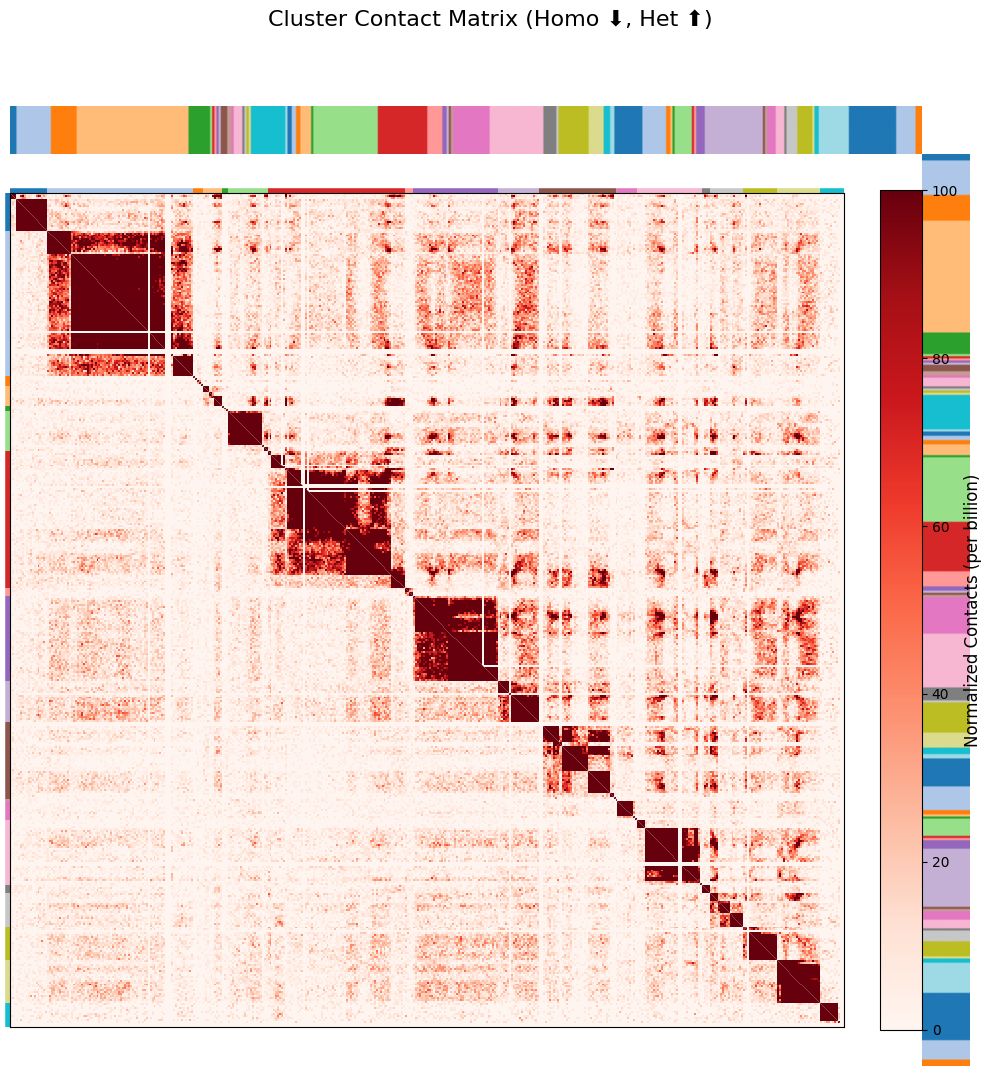

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle, Polygon
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm

# ==== 参数 ====
mat_homo = Homo_interaction_rpb_matrix_100kb
mat_het = Het_interaction_rpb_matrix_100kb
vmin = 0
vmax = 100
n = mat_homo.shape[0]

# === cluster 颜色 ===
bin_cluster_series = cluster_to_bin_mapping_all_100kb.drop_duplicates('bin_idx').set_index('bin_idx')['cluster_idx']
bin_cluster_series = bin_cluster_series.sort_index()
bin_clusters = bin_cluster_series.values
cluster_ids = np.unique(bin_clusters)
cmap = cm.get_cmap('tab20', 20)
cluster_color_map = {clu: cmap(i % 20) for i, clu in enumerate(cluster_ids)}
cluster_colors = np.array([cluster_color_map[clu] for clu in bin_clusters])

# === 染色体颜色（可选）===
bin_chrom_series = cluster_to_bin_mapping_all_100kb.drop_duplicates('bin_idx').set_index('bin_idx')['cluster_chrom']
bin_chrom_series = bin_chrom_series.sort_index()
chroms = bin_chrom_series.values
chrom_order = list(dict.fromkeys(chroms))
chrom_color_map = {chrom: plt.cm.tab20(i % 20) for i, chrom in enumerate(chrom_order)}
chrom_regions = [(chrom, np.where(chroms == chrom)[0].min(), np.where(chroms == chrom)[0].max())
                 for chrom in chrom_order if np.any(chroms == chrom)]

# ==== 绘图 ====
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 2, width_ratios=(0.95, 0.05), height_ratios=(0.05, 0.95),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)

ax_matrix = fig.add_subplot(gs[1, 0])

# 逐格绘制（含对角线分割）
for i in range(n):
    for j in range(n):
        if i < j:
            val = mat_het[i, j]
            if np.isnan(val): continue
            color = plt.cm.Reds(np.clip((val - vmin) / (vmax - vmin), 0, 1))
            ax_matrix.add_patch(Rectangle((j, i), 1, 1, facecolor=color, edgecolor='none'))
        elif i > j:
            val = mat_homo[i, j]
            if np.isnan(val): continue
            color = plt.cm.Reds(np.clip((val - vmin) / (vmax - vmin), 0, 1))
            ax_matrix.add_patch(Rectangle((j, i), 1, 1, facecolor=color, edgecolor='none'))
        else:
            val_het = mat_het[i, j]
            val_homo = mat_homo[i, j]
            if not np.isnan(val_het):
                color_het = plt.cm.Reds(np.clip((val_het - vmin) / (vmax - vmin), 0, 1))
                ax_matrix.add_patch(Polygon([[j, i], [j + 1, i], [j + 1, i + 1]],
                                            facecolor=color_het, edgecolor='none'))
            if not np.isnan(val_homo):
                color_homo = plt.cm.Reds(np.clip((val_homo - vmin) / (vmax - vmin), 0, 1))
                ax_matrix.add_patch(Polygon([[j, i], [j, i + 1], [j + 1, i + 1]],
                                            facecolor=color_homo, edgecolor='none'))

# 坐标设置
ax_matrix.set_xlim(0, n)
ax_matrix.set_ylim(n, 0)
ax_matrix.set_aspect('equal')
ax_matrix.set_xticks([])
ax_matrix.set_yticks([])
ax_matrix.set_xlabel('')
ax_matrix.set_ylabel('')

# ==== cluster 颜色条 ====
ax_y_color = fig.add_subplot(gs[1, 1])
ax_y_color.imshow(cluster_colors[:, np.newaxis], aspect='auto', origin='upper')
ax_y_color.axis('off')

ax_x_color = fig.add_subplot(gs[0, 0])
ax_x_color.imshow(cluster_colors[np.newaxis, :], aspect='auto', origin='lower')
ax_x_color.axis('off')

# ✅ 如果你想换成染色体彩条，就替换为 chrom_colors，方法和上面类似

# ==== 染色体标注条 ====
for chrom, start, end in chrom_regions:
    color = chrom_color_map[chrom]
    ax_matrix.plot([start, end + 1], [-1, -1], color=color, linewidth=4, solid_capstyle='butt', clip_on=False)
    ax_matrix.plot([-1, -1], [start, end + 1], color=color, linewidth=4, solid_capstyle='butt', clip_on=False)

# 颜色条
sm = ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax_matrix, fraction=0.046, pad=0.04)
cbar.set_label('Normalized Contacts (per billion)', fontsize=12)

plt.suptitle('Cluster Contact Matrix (Homo ⬇, Het ⬆)', fontsize=16)
plt.savefig('../plots_v1/cluster_split_heatmap_triangles.pdf', dpi=300)
plt.show()


/tmp/ipykernel_1142607/4210565277.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', 20)


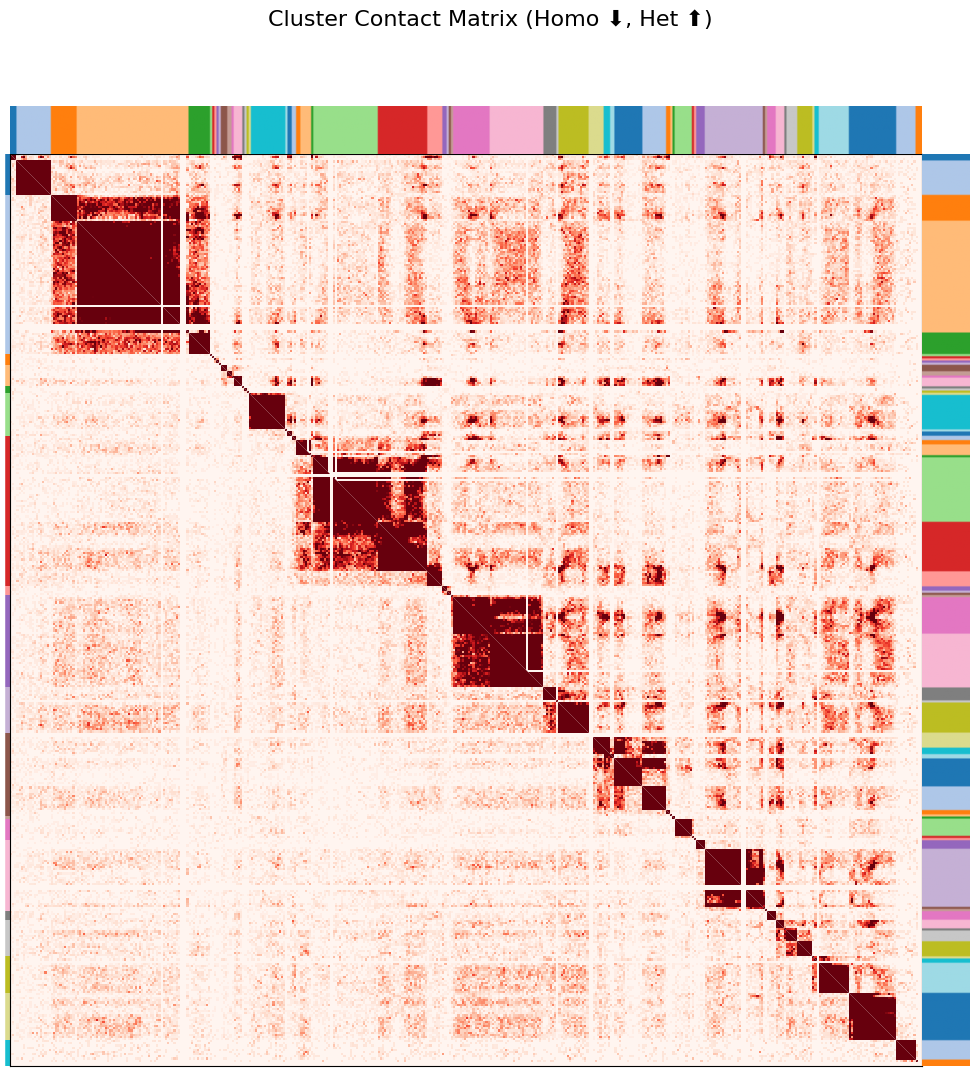

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle, Polygon
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm

# ==== 参数 ====
mat_homo = Homo_interaction_rpb_matrix_100kb
mat_het = Het_interaction_rpb_matrix_100kb
vmin = 0
vmax = 100
n = mat_homo.shape[0]

# === cluster 颜色 ===
bin_cluster_series = cluster_to_bin_mapping_all_100kb.drop_duplicates('bin_idx').set_index('bin_idx')['cluster_idx']
bin_cluster_series = bin_cluster_series.sort_index()
bin_clusters = bin_cluster_series.values
cluster_ids = np.unique(bin_clusters)
cmap = cm.get_cmap('tab20', 20)
cluster_color_map = {clu: cmap(i % 20) for i, clu in enumerate(cluster_ids)}
cluster_colors = np.array([cluster_color_map[clu] for clu in bin_clusters])

# === 染色体颜色（可选）===
bin_chrom_series = cluster_to_bin_mapping_all_100kb.drop_duplicates('bin_idx').set_index('bin_idx')['cluster_chrom']
bin_chrom_series = bin_chrom_series.sort_index()
chroms = bin_chrom_series.values
chrom_order = list(dict.fromkeys(chroms))
chrom_color_map = {chrom: plt.cm.tab20(i % 20) for i, chrom in enumerate(chrom_order)}
chrom_regions = [(chrom, np.where(chroms == chrom)[0].min(), np.where(chroms == chrom)[0].max())
                 for chrom in chrom_order if np.any(chroms == chrom)]

# ==== 绘图 ====
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 2, width_ratios=(0.95, 0.05), height_ratios=(0.05, 0.95),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)

ax_matrix = fig.add_subplot(gs[1, 0])

# 逐格绘制（含对角线分割）
for i in range(n):
    for j in range(n):
        if i < j:
            val = mat_het[i, j]
            if np.isnan(val): continue
            color = plt.cm.Reds(np.clip((val - vmin) / (vmax - vmin), 0, 1))
            ax_matrix.add_patch(Rectangle((j, i), 1, 1, facecolor=color, edgecolor='none'))
        elif i > j:
            val = mat_homo[i, j]
            if np.isnan(val): continue
            color = plt.cm.Reds(np.clip((val - vmin) / (vmax - vmin), 0, 1))
            ax_matrix.add_patch(Rectangle((j, i), 1, 1, facecolor=color, edgecolor='none'))
        else:
            val_het = mat_het[i, j]
            val_homo = mat_homo[i, j]
            if not np.isnan(val_het):
                color_het = plt.cm.Reds(np.clip((val_het - vmin) / (vmax - vmin), 0, 1))
                ax_matrix.add_patch(Polygon([[j, i], [j + 1, i], [j + 1, i + 1]],
                                            facecolor=color_het, edgecolor='none'))
            if not np.isnan(val_homo):
                color_homo = plt.cm.Reds(np.clip((val_homo - vmin) / (vmax - vmin), 0, 1))
                ax_matrix.add_patch(Polygon([[j, i], [j, i + 1], [j + 1, i + 1]],
                                            facecolor=color_homo, edgecolor='none'))

# 坐标设置
ax_matrix.set_xlim(0, n)
ax_matrix.set_ylim(n, 0)
ax_matrix.set_aspect('equal')
ax_matrix.set_xticks([])
ax_matrix.set_yticks([])
ax_matrix.set_xlabel('')
ax_matrix.set_ylabel('')

# ==== cluster 颜色条 ====
ax_y_color = fig.add_subplot(gs[1, 1])
ax_y_color.imshow(cluster_colors[:, np.newaxis], aspect='auto', origin='upper')
ax_y_color.axis('off')

ax_x_color = fig.add_subplot(gs[0, 0])
ax_x_color.imshow(cluster_colors[np.newaxis, :], aspect='auto', origin='lower')
ax_x_color.axis('off')

# ✅ 如果你想换成染色体彩条，就替换为 chrom_colors，方法和上面类似

# ==== 染色体标注条 ====
for chrom, start, end in chrom_regions:
    color = chrom_color_map[chrom]
    ax_matrix.plot([start, end + 1], [-1, -1], color=color, linewidth=4, solid_capstyle='butt', clip_on=False)
    ax_matrix.plot([-1, -1], [start, end + 1], color=color, linewidth=4, solid_capstyle='butt', clip_on=False)

# 颜色条
# sm = ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# cbar = plt.colorbar(sm, ax=ax_matrix, fraction=0.046, pad=0.04)
# cbar.set_label('Normalized Contacts (per billion)', fontsize=12)

plt.suptitle('Cluster Contact Matrix (Homo ⬇, Het ⬆)', fontsize=16)
plt.savefig('../plots_v1/cluster_split_heatmap_triangles_without_colorbar.pdf', dpi=300)
plt.show()


/tmp/ipykernel_1142607/1394731103.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_cluster = cm.get_cmap('tab20', 20)


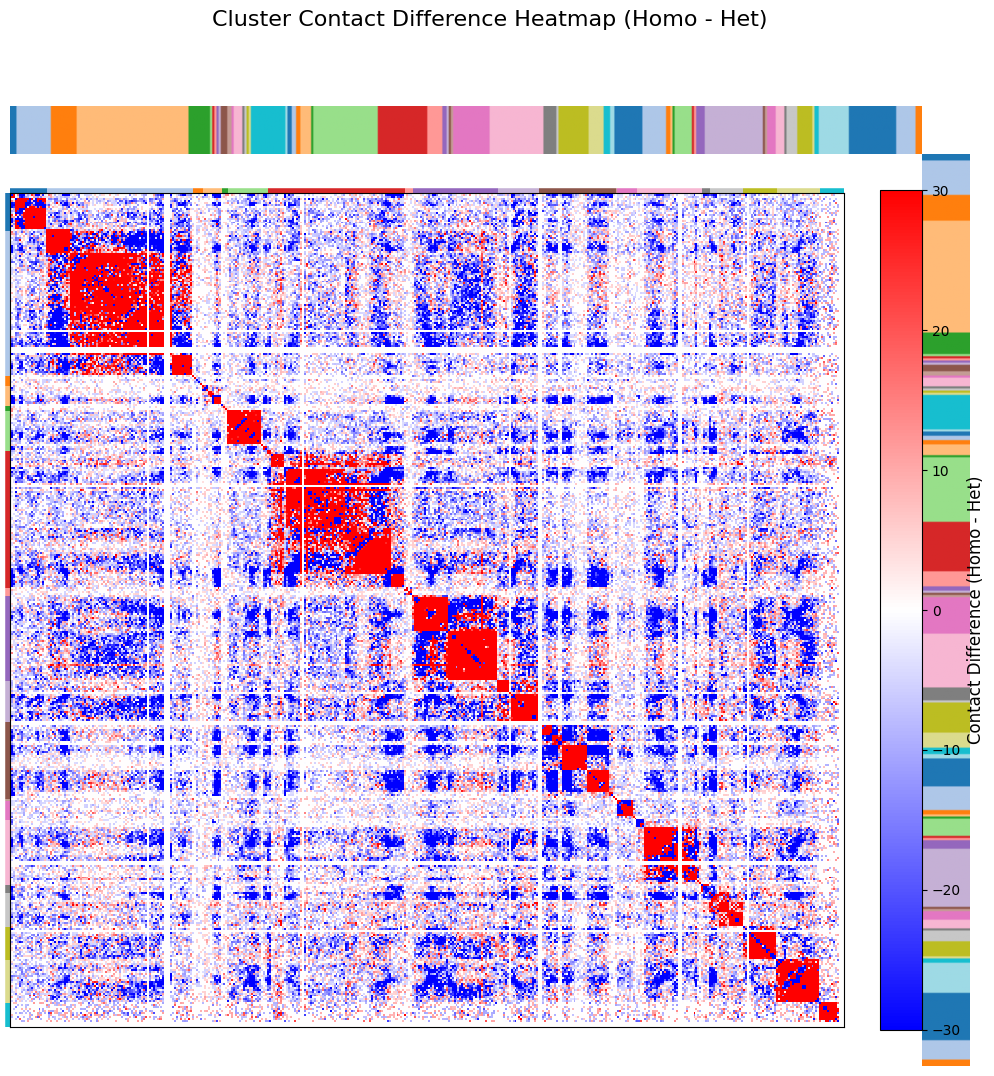

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm

# === 计算差值矩阵 ===
diff_mat = mat_homo - mat_het
n = diff_mat.shape[0]

# cluster 颜色准备（和你一样）
bin_cluster_series = cluster_to_bin_mapping_all_100kb.drop_duplicates('bin_idx').set_index('bin_idx')['cluster_idx']
bin_cluster_series = bin_cluster_series.sort_index()
bin_clusters = bin_cluster_series.values
cluster_ids = np.unique(bin_clusters)
cmap_cluster = cm.get_cmap('tab20', 20)
cluster_color_map = {clu: cmap_cluster(i % 20) for i, clu in enumerate(cluster_ids)}
cluster_colors = np.array([cluster_color_map[clu] for clu in bin_clusters])

# 染色体区域和颜色（和你一样）
bin_chrom_series = cluster_to_bin_mapping_all_100kb.drop_duplicates('bin_idx').set_index('bin_idx')['cluster_chrom']
bin_chrom_series = bin_chrom_series.sort_index()
chroms = bin_chrom_series.values
chrom_order = list(dict.fromkeys(chroms))
chrom_color_map = {chrom: plt.cm.tab20(i % 20) for i, chrom in enumerate(chrom_order)}
chrom_regions = [(chrom, np.where(chroms == chrom)[0].min(), np.where(chroms == chrom)[0].max())
                 for chrom in chrom_order if np.any(chroms == chrom)]

# === 绘图 ===
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 2, width_ratios=(0.95, 0.05), height_ratios=(0.05, 0.95),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)

ax_matrix = fig.add_subplot(gs[1, 0])
im = ax_matrix.imshow(diff_mat, cmap='bwr', interpolation='nearest', vmin=-30, vmax=30, origin='upper', aspect='equal')

ax_matrix.set_xlim(0, n)
ax_matrix.set_ylim(n, 0)
ax_matrix.set_xticks([])
ax_matrix.set_yticks([])
ax_matrix.set_xlabel('')
ax_matrix.set_ylabel('')

# cluster 颜色条
ax_y_color = fig.add_subplot(gs[1, 1])
ax_y_color.imshow(cluster_colors[:, np.newaxis], aspect='auto', origin='upper')
ax_y_color.axis('off')

ax_x_color = fig.add_subplot(gs[0, 0])
ax_x_color.imshow(cluster_colors[np.newaxis, :], aspect='auto', origin='lower')
ax_x_color.axis('off')

# 染色体分区彩条（覆盖主图边缘）
for chrom, start, end in chrom_regions:
    color = chrom_color_map[chrom]
    ax_matrix.plot([start, end + 1], [-1, -1], color=color, linewidth=4, solid_capstyle='butt', clip_on=False)
    ax_matrix.plot([-1, -1], [start, end + 1], color=color, linewidth=4, solid_capstyle='butt', clip_on=False)

# 颜色条
sm = ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=-30, vmax=30))
cbar = plt.colorbar(sm, ax=ax_matrix, fraction=0.046, pad=0.04)
cbar.set_label('Contact Difference (Homo - Het)', fontsize=12)

plt.suptitle('Cluster Contact Difference Heatmap (Homo - Het)', fontsize=16)
plt.savefig('../plots_v1/cluster_diff_heatmap_100kb.pdf', dpi=300)
plt.show()


/tmp/ipykernel_1142607/741148636.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_cluster = cm.get_cmap('tab20', 20)


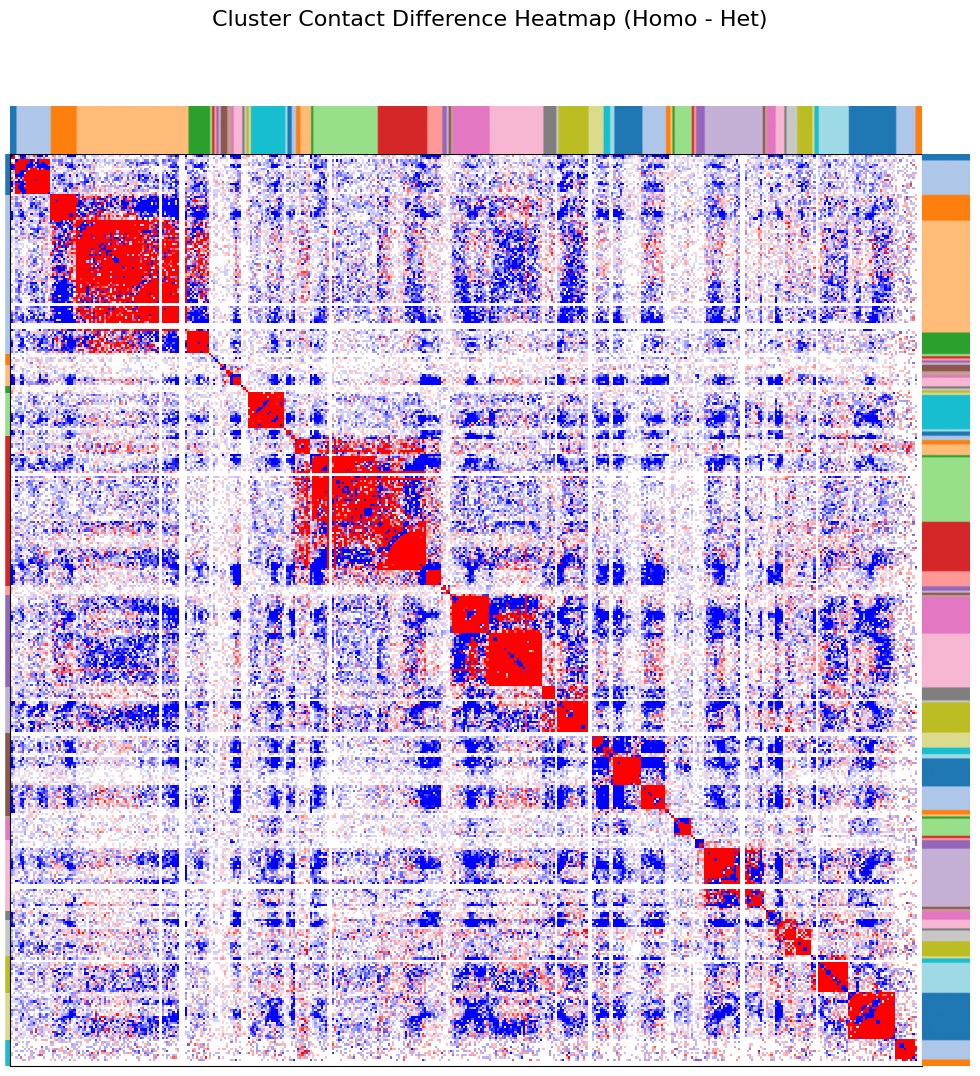

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm

# === 计算差值矩阵 ===
diff_mat = mat_homo - mat_het
n = diff_mat.shape[0]

# cluster 颜色准备（和你一样）
bin_cluster_series = cluster_to_bin_mapping_all_100kb.drop_duplicates('bin_idx').set_index('bin_idx')['cluster_idx']
bin_cluster_series = bin_cluster_series.sort_index()
bin_clusters = bin_cluster_series.values
cluster_ids = np.unique(bin_clusters)
cmap_cluster = cm.get_cmap('tab20', 20)
cluster_color_map = {clu: cmap_cluster(i % 20) for i, clu in enumerate(cluster_ids)}
cluster_colors = np.array([cluster_color_map[clu] for clu in bin_clusters])

# 染色体区域和颜色（和你一样）
bin_chrom_series = cluster_to_bin_mapping_all_100kb.drop_duplicates('bin_idx').set_index('bin_idx')['cluster_chrom']
bin_chrom_series = bin_chrom_series.sort_index()
chroms = bin_chrom_series.values
chrom_order = list(dict.fromkeys(chroms))
chrom_color_map = {chrom: plt.cm.tab20(i % 20) for i, chrom in enumerate(chrom_order)}
chrom_regions = [(chrom, np.where(chroms == chrom)[0].min(), np.where(chroms == chrom)[0].max())
                 for chrom in chrom_order if np.any(chroms == chrom)]

# === 绘图 ===
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(2, 2, width_ratios=(0.95, 0.05), height_ratios=(0.05, 0.95),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)

ax_matrix = fig.add_subplot(gs[1, 0])
im = ax_matrix.imshow(diff_mat, cmap='bwr', interpolation='nearest', vmin=-30, vmax=30, origin='upper', aspect='equal')

ax_matrix.set_xlim(0, n)
ax_matrix.set_ylim(n, 0)
ax_matrix.set_xticks([])
ax_matrix.set_yticks([])
ax_matrix.set_xlabel('')
ax_matrix.set_ylabel('')

# cluster 颜色条
ax_y_color = fig.add_subplot(gs[1, 1])
ax_y_color.imshow(cluster_colors[:, np.newaxis], aspect='auto', origin='upper')
ax_y_color.axis('off')

ax_x_color = fig.add_subplot(gs[0, 0])
ax_x_color.imshow(cluster_colors[np.newaxis, :], aspect='auto', origin='lower')
ax_x_color.axis('off')

# 染色体分区彩条（覆盖主图边缘）
for chrom, start, end in chrom_regions:
    color = chrom_color_map[chrom]
    ax_matrix.plot([start, end + 1], [-1, -1], color=color, linewidth=4, solid_capstyle='butt', clip_on=False)
    ax_matrix.plot([-1, -1], [start, end + 1], color=color, linewidth=4, solid_capstyle='butt', clip_on=False)

# 颜色条
# sm = ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=-30, vmax=30))
# cbar = plt.colorbar(sm, ax=ax_matrix, fraction=0.046, pad=0.04)
# cbar.set_label('Contact Difference (Homo - Het)', fontsize=12)

plt.suptitle('Cluster Contact Difference Heatmap (Homo - Het)', fontsize=16)
plt.savefig('../plots_v1/cluster_diff_heatmap_100kb_without_colorbar.pdf', dpi=300)
plt.show()
